In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os

import torch

In [2]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:4')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce RTX 2080 Ti


# Arguments

In [42]:
# @title Arguments
parser = argparse.ArgumentParser(description='Actor Critic')

parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
parser.add_argument('--epochs', default=64, type=int, metavar='N', help='Number of epochs for training agent.')
parser.add_argument('--episodes', default=1000, type=int, metavar='N', help='Number of episodes for training agent.')
parser.add_argument('--lr', '--learning-rate', default=0.005, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', default=0.0001, type=float, help='Weight decay for training optimizer')
parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
parser.add_argument('--model-name', default="PPO", type=str, help='Model name for saving model.')
parser.add_argument('--gamma', default=0.99, type=float, metavar='N', help='The discount factor as mentioned in the previous section')

# Model
parser.add_argument("--latent1", default=256, required=False, help="Latent Space Size for first layer of network.")
parser.add_argument("--latent2", default=256, required=False, help="Latent Space Size for second layer of network.")

# Env Properties
parser.add_argument('--control_size', default=100, type=int, help='Beacon and Attacker Control group size')
parser.add_argument('--gene_size', default=100, type=int, help='States gene size')
parser.add_argument('--beacon_size', default=60, type=int, help='Beacon population size')
parser.add_argument('--victim_prob', default=1, type=float, help='Victim inside beacon or not!')
parser.add_argument('--max_queries', default=20, type=int, help='Maximum queries per episode')
parser.add_argument('--attacker_type', default="optimal", choices=["random", "optimal", "agent"], type=str, help='Type of the attacker')


parser.add_argument('--pop_reset_freq', default=10000, type=int, help='Reset Population Frequency (Epochs)')
parser.add_argument('--update_freq', default=10, type=int, help='Train Agent model frequency')
parser.add_argument('--plot-freq', default=40, type=int, metavar='N', help='Plot Frequencies')
parser.add_argument('--val-freq', default=50, type=int, metavar='N', help='Validation frequencies')


parser.add_argument("--state_dim", default=(4,), required=False, help="State Dimension")
parser.add_argument("--n-actions", default=1, required=False, help="Actions Count for each state")


# utils
parser.add_argument('--resume', default="", type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--save-dir', default='./results', type=str, metavar='PATH', help='path to cache (default: none)')

# args = parser.parse_args()  # running in command line
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
if args.save_dir == '':
    args.save_dir = "./"

args.results_dir = args.save_dir

if not os.path.exists(args.results_dir):
      os.makedirs(args.results_dir)

args.device = device

print(args)

Namespace(data='/mnt/kerem/CEU', epochs=64, episodes=1000, lr=0.005, wd=0.0001, seed=3, model_name='PPO', gamma=0.99, latent1=256, latent2=256, control_size=100, gene_size=100, beacon_size=60, victim_prob=1, max_queries=20, attacker_type='optimal', pop_reset_freq=10000, update_freq=10, plot_freq=40, val_freq=50, state_dim=(4,), n_actions=1, resume='', save_dir='./results', results_dir='./results', device=device(type='cuda', index=4))


# Read Data

In [4]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join(args.data, "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join(args.data, "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [38]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join(args.data, "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

In [39]:
beacon.shape, reference.shape, binary.shape, maf_values.shape

((4029840, 164), (4029840, 1), (4029840, 164), (4029840,))

# PPO

In [40]:
has_continuous_action_space = True                

action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.0025       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.05                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)

################ PPO hyperparameters ################
K_epochs = 200          # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Victim is inside the Beacon!
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Started training at (GMT) :  2024-04-28 00:57:05
current logging run number for  :  3
logging at : ./results/PPO__log_3.csv
save checkpoint path : ./results/weights/PPO_3.pth
Episode:  0
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  0
Episode Reward:  tensor([1.])
Episode Privacy Reward:  tensor(0.)
Episode Utility Reward:  [1.]
Episode Pvalues:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Min Episode pvalue:  tensor(0.)


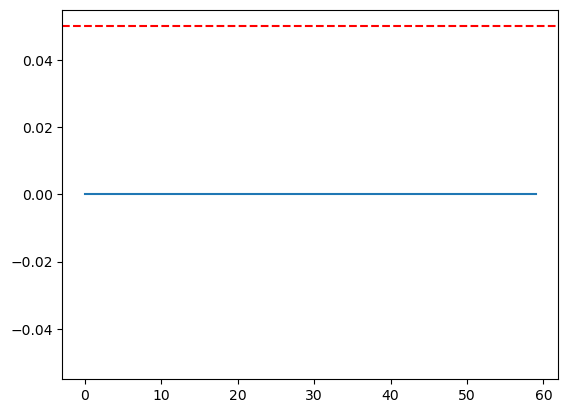

Victim Episode pvalue:  tensor(0.)
Episode:  1
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  2
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  3
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  4
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  5
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  6
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  7
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  8
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  9
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  10
torch.Size([60, 100]) torch.Size([60, 100]) torch.Size([60, 100])
Episode:  10
Episode Reward:  tensor([0.])
Episode Privacy Reward:  tensor(0.)
Episode Utility Reward:  [0.]
Episode Pvalues:  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

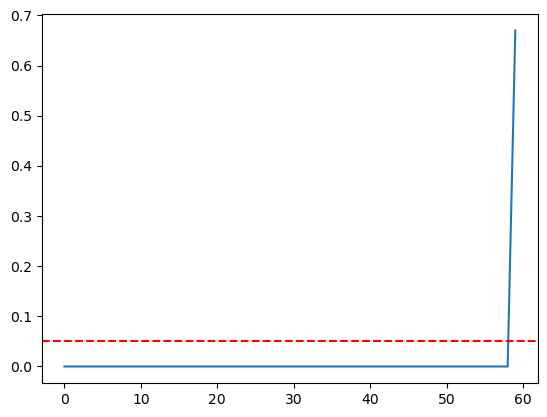

Victim Episode pvalue:  tensor(0.6700)
updating the agent
Episode : 10 		 Timestep : 11 		 Average Reward : tensor([0.8000])


In [43]:
%load_ext autoreload
%autoreload 2
from environment import BeaconEnv
from ppo import PPO
from engine import train, val

def main():
    env = BeaconEnv(args, beacon, maf_values, binary)
    state_dim = (args.beacon_size + args.control_size) * args.gene_size * 5
    action_dim = env.action_space.shape[0]

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    train(args, env, ppo_agent)

    # val(args, ppo_agent, env)

if __name__ == '__main__':
    main()

In [179]:
import torch

# Given tensors
tensor1 = torch.tensor([1, 2])  # Size: [2]
tensor2 = torch.tensor([[[1, 2, 3, 4, 5],
                          [6, 7, 8, 9, 10],
                          [11, 12, 13, 14, 15],
                          [16, 17, 18, 19, 20]],
                         [[21, 22, 23, 24, 25],
                          [26, 27, 28, 29, 30],
                          [31, 32, 33, 34, 35],
                          [36, 37, 38, 39, 40]]])  # Size: [1, 2, 4, 5]



In [180]:
tensor2.size()

torch.Size([2, 4, 5])

In [183]:
# Reshape tensor1 to [2, 1, 1, 1] for broadcasting
reshaped_tensor1 = tensor1.view(2, 1)

# Repeat tensor1 to match the size of tensor2's third dimension
repeated_tensor1 = reshaped_tensor1.repeat(1, 4)

# # Update tensor2 by replacing its third dimension with repeated_tensor1
# tensor2[:, :, :, 4] = repeated_tensor1

# print(tensor2)
repeated_tensor1

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2]])

In [184]:
tensor2[:, :, 4] = repeated_tensor1

In [185]:
tensor2

tensor([[[ 1,  2,  3,  4,  1],
         [ 6,  7,  8,  9,  1],
         [11, 12, 13, 14,  1],
         [16, 17, 18, 19,  1]],

        [[21, 22, 23, 24,  2],
         [26, 27, 28, 29,  2],
         [31, 32, 33, 34,  2],
         [36, 37, 38, 39,  2]]])

In [19]:
genome = torch.as_tensor(0)
maf =   torch.as_tensor(0.001)
response =  torch.as_tensor(6.2364e-01)


DN_i = (1 - maf).pow(2 * 3) 
DN_i_1 = (1 - maf).pow(2 * 3 - 2)

# Genome == 1
log1 = torch.log(DN_i) - torch.log(0.001 * DN_i_1)
log2 = torch.log((0.001 * DN_i_1 * (1 - DN_i))) - torch.log(DN_i * (1 - 0.001 * DN_i_1))

# Genome == 0
log3 = torch.log(DN_i) - torch.log((1 - 0.001) * DN_i_1)
log4 = torch.log((1 - 0.001) * DN_i_1 * (1 - DN_i)) - torch.log(DN_i * (1 - DN_i_1 * (1 - 0.001)))

x_hat_i = (genome * response) + ((1 - genome) * (1 - response))
lrt = (log1 + log2 * x_hat_i)* genome + (log3 + log4 * x_hat_i) * (1 - genome)
        # print("lrts, lrts.size()", lrts, lrts.size())
lrt

tensor(0.0678)

In [20]:
0.0991 + 0.0678

0.1669